In [1]:
import pandas as pd
import seaborn as sns
from gc import collect
from scipy.sparse import csr_matrix
from scipy.sparse import triu as sparse_triu
import igraph as ig
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
x = array([.5, 2])
mean(x)

1.25

In [4]:
log(x)

array([-0.69314718,  0.69314718])

In [3]:
mean(log(x))

0.0

In [2]:
data_directory = '../data/PatentsView/'

In [3]:
patent_classes = pd.read_csv(data_directory+'cpc_current.tsv', sep='\t')

In [4]:
patent_classes = patent_classes[patent_classes['category']=='primary']

In [5]:
patent_classes.drop(['uuid', 'category', 'sequence'], axis=1, inplace=True)

In [6]:
patent_classes['subgroup_aggregated_id'] = patent_classes['subgroup_id'].map(lambda x: x.split('/')[0])

In [7]:
class_types = ['section', 'subsection', 'group', 'subgroup_aggregated', 'subgroup']

In [8]:
class_lookups={}
for c in class_types:
    print(c)
    values = sort(patent_classes[c+'_id'].unique())
    n = len(values)
    print(n)
    lookup = pd.Series(index=values,data=arange(len(values)))
    class_lookups[c] = lookup
    patent_classes[c+'_id'] = lookup.ix[patent_classes[c+'_id']].values

section
8
subsection
122
group
625
subgroup_aggregated
7085
subgroup
150002


In [9]:
patent_years = pd.read_csv(data_directory+'patent.tsv', sep='\t', usecols=['id', 'date'])

patent_years.rename(columns={'id':'patent_id'}, inplace=True)
patent_years['patent_id'] = pd.to_numeric(patent_years['patent_id'], errors='coerce')

patent_years['date'] = pd.to_datetime(patent_years['date'], errors='coerce')
patent_years['year'] = pd.DatetimeIndex(patent_years['date']).year

patent_years.dropna(inplace=True)
patent_years.set_index('patent_id', inplace=True)
patent_years.index = patent_years.index.values.astype('int')

/home/jeffrey_alstott/anaconda3/lib/python3.4/site-packages/IPython/core/interactiveshell.py:2705: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [34]:
patent_classes['year'] = patent_years.ix[patent_classes['patent_id'],'year'].values

In [11]:
years = arange(1976,2016)

In [35]:
from scipy.sparse import csr_matrix
def cooccurrence_counts(AB, A,B,n=None):
    if n is not None:
        pairings = csr_matrix((ones_like(AB[A]),
                               (AB[A], AB[B])),
                             shape=(AB[A].max()+1,n))
    else:
        pairings = csr_matrix((ones_like(AB[A]),
                               (AB[A], AB[B]))
                              )
    return (pairings.T * pairings)
    
#     return cooccurrences
#     if n is not None:
#         shape=(n,n)
#     all_cooccurrences = zeros((max(classes)+1, max(classes)+1))
#     all_cooccurrences[:present_cooccurrence.shape[0], 
#                           :present_cooccurrence.shape[1]] = present_cooccurrence

In [ ]:
cooccurrences = {}

for c in class_types:
    print(c)
    cooccurrences[c] = {}
    for year in years:
        cooccurrences[c][year] =  cooccurrence_counts(patent_classes[patent_classes['year']==year], 
                                                      'patent_id', c+'_id',
                                                      n=class_lookups[c].shape[0])

section
subsection
group
subgroup_aggregated
subgroup


In [ ]:
for c in class_types:
    print(c)
    for year in years:
        cooccurrences[c][year].setdiag(0)

section
subsection
group
subgroup_aggregated


/home/jeffrey_alstott/anaconda3/lib/python3.4/site-packages/scipy/sparse/compressed.py:730: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


subgroup


In [ ]:
cooccurrences_cumsum = {}
for c in class_types:
    print(c)
    cooccurrences_cumsum[c] = {}
    first_year = True
    for year in years:
        if first_year:
            cooccurrences_cumsum[c][year] = cooccurrences[c][year]
            first_year = False
        else:
            cooccurrences_cumsum[c][year] = cooccurrences[c][year] + cooccurrences_cumsum[c][year-1]

In [ ]:
from igraph import Graph
def network_properties(g, c, df):
    if len(g)==1 or len(unique(g))==1:
        return pd.Series({'density': nan, 
                      'n': 1,
                      'isoclass': 0,
                      })
    else:
        year = df.ix[g.index[0],'year']
        net = sparse_triu(cooccurrences_cumsum[c][year-1][atleast_2d(unique(g)).T,unique(g)])
        sources, targets = net.nonzero()
    #     weights = net[sources, targets]
    #     weights = array(weights)[0] #Need to convert Scipy's matrix format into a form appropriate for igraph
        g = Graph(n=net.shape[0], edges=list(zip(sources, targets)), directed=False, 
    #               edge_attrs={'weight': weights}
                 )
        path_lengths = array(g.shortest_paths())
        return pd.Series({'density': g.density(), 
                          'n': g.vcount(),
                          'isoclass': g.isoclass() if g.vcount()==3 or g.vcount()==4 else 0,
                          'transitivity': g.transitivity_undirected(),
                          'V_density': (path_lengths==2).sum()/2 if g.vcount()>2 else nan,
                          })
import functools

In [ ]:
class_types

In [ ]:
from time import time

network_dict = {}
times = {}
for c in class_types:
    if c=='section':
        continue
    print(c)
    t = time()
    fnc = functools.partial(network_properties, c=c, df=patent_classes)
    network_dict[c] = patent_classes[patent_classes['year']>1976].groupby('patent_id')[c+'_id'].apply(fnc)
    times[c] = time()-t
    print(time()-t)

In [ ]:
for k in network_dict.keys():
    network_dict[k] = pd.DataFrame(network_dict[k]).unstack()

In [ ]:
patent_properties = pd.concat(network_dict, axis=1)
patent_properties.columns = patent_properties.columns.droplevel(level=1)

In [ ]:
patent_properties['year'] = patent_years.ix[patent_properties.index.values,'year'].values

In [ ]:
# c = 'section'

# network_densities = pd.Series(index=patent_years.index)
# for name, g in patent_classes[patent_classes['year']>1976].groupby('patent_id'):
#     year = g['year'].values[0]
#     class_inds = g[c+'_id'].values
#     binary_network = cooccurrences_cumsum[c][year-1][atleast_2d(class_inds).T,class_inds]>0
#     network_densities.ix[name] = binary_network.mean()

Citations Counts
===

In [ ]:
citations = pd.read_csv(data_directory+'uspatentcitation.tsv', sep='\t')

In [ ]:
citations['citation_id'] = pd.to_numeric(citations['citation_id'],errors='coerce')

patent_forward_citations = citations['citation_id'].value_counts().reset_index()

patent_forward_citations.rename(columns={'index':'patent_id',
                                         'citation_id':'count'
                                         },
                                inplace=True
                               ) 

# patent_forward_citations['patent_id'] = pd.to_numeric(patent_forward_citations['patent_id'],
#                                                      errors='coerce')

patent_forward_citations.dropna(inplace=True)
patent_forward_citations['patent_id'] = patent_forward_citations['patent_id'].values.astype('int')
patent_forward_citations.set_index('patent_id', inplace=True)

# patent_forward_citations.index = patent_forward_citations.index.values.astype('int')

In [ ]:
from gc import collect
del(citations)
collect()

In [ ]:
patent_properties['citations_forward'] = patent_forward_citations.ix[patent_properties.index.values].fillna(0).values

In [3]:
store = pd.HDFStore(data_directory+'patent_properties.h5')
# store['patent_properties'] = patent_properties
patent_properties = store['patent_properties']
store.close()

In [4]:
patent_properties['citations_forward_mean_for_year'] = patent_properties.groupby('year')['citations_forward'].transform('mean')

In [5]:
patent_properties['citations_forward_relative_to_year'] = patent_properties['citations_forward'].values/patent_properties['citations_forward_mean_for_year'].values

In [ ]:
# import powerlaw
# fit = powerlaw.Fit(patent_properties['citations_forward'].values+1, xmin=1)
# fit.distribution_compare('exponential', 'power_law')

0.0    102784
1.0    186798
2.0    145326
3.0    394357
Name: (subgroup, isoclass), dtype: int64
0
102784


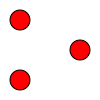

1
186798


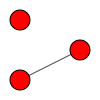

2
145326


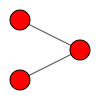

3
394357


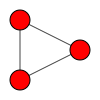

In [7]:
vc = patent_properties[patent_properties[('subgroup','n')]==3][('subgroup', 'isoclass')].value_counts().sort_index()
print(vc)
from IPython.display import Image
for i in range(4):
    ig.plot(ig.Graph.Isoclass(3, i, directed=False), "isoclass_3_%d.png"%i, bbox=(100, 100), layout="circle")
    fig = Image(filename=('isoclass_3_%d.png'%i))
    print(i)
    print(vc.ix[i])
    display(fig)

0.0      24373
1.0      47765
2.0      38272
3.0      41805
4.0       8225
5.0      13930
6.0      19367
7.0      56572
8.0       2235
9.0      57520
10.0    195255
Name: (subgroup, isoclass), dtype: int64
0
24373


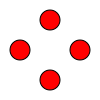

1
47765


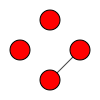

2
38272


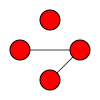

3
41805


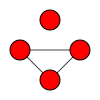

4
8225


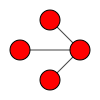

5
13930


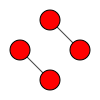

6
19367


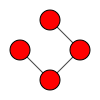

7
56572


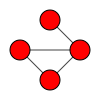

8
2235


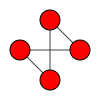

9
57520


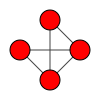

10
195255


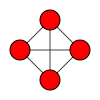

In [8]:
vc = patent_properties[patent_properties[('subgroup','n')]==4][('subgroup', 'isoclass')].value_counts().sort_index()
print(vc)
from IPython.display import Image
for i in range(11):
    ig.plot(ig.Graph.Isoclass(4, i, directed=False), "isoclass_4_%d.png"%i, bbox=(100, 100), layout="circle")
    fig = Image(filename=('isoclass_%d.png'%i))
    print(i)
    print(vc.ix[i])
    display(fig)

In [9]:
patent_properties[((patent_properties[('subgroup','n')]==3) *
                   (patent_properties['year']<2005)
                   )].groupby([('subgroup','isoclass')])['citations_forward_relative_to_year'].mean()

/home/jeffrey_alstott/anaconda3/lib/python3.4/site-packages/pandas/computation/expressions.py:181: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


(subgroup, isoclass)
0.0    1.059498
1.0    1.004420
2.0    0.991824
3.0    1.005161
Name: citations_forward_relative_to_year, dtype: float64

/home/jeffrey_alstott/anaconda3/lib/python3.4/site-packages/pandas/computation/expressions.py:181: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


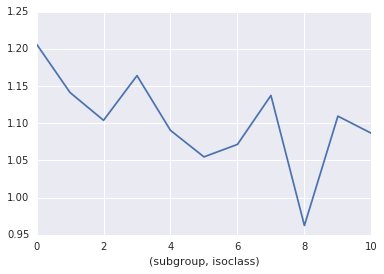

In [23]:
patent_properties[((patent_properties[('subgroup','n')]==4) *
                   (patent_properties['year']<2005)
                   )].groupby([('subgroup','isoclass')])['citations_forward_relative_to_year'].mean().plot()

/home/jeffrey_alstott/anaconda3/lib/python3.4/site-packages/pandas/computation/expressions.py:181: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


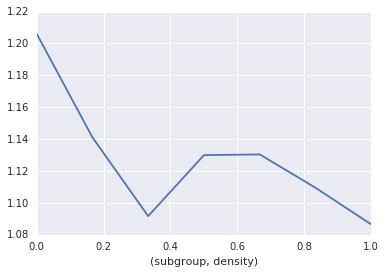

In [62]:
patent_properties[((patent_properties[('subgroup','n')]==4) *
                   (patent_properties['year']<2005)
                   )].groupby([('subgroup','density')])['citations_forward_relative_to_year'].mean().plot()

/home/jeffrey_alstott/anaconda3/lib/python3.4/site-packages/pandas/computation/expressions.py:181: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


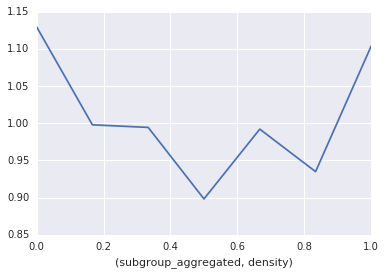

In [63]:
patent_properties[((patent_properties[('subgroup','n')]==4) *
                   (patent_properties['year']<2005)
                   )].groupby([('subgroup_aggregated','density')])['citations_forward_relative_to_year'].mean().plot()

/home/jeffrey_alstott/anaconda3/lib/python3.4/site-packages/pandas/computation/expressions.py:181: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


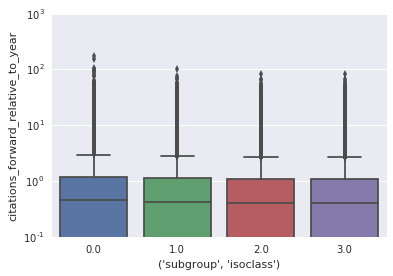

In [80]:
df = patent_properties[((patent_properties[('subgroup','n')]==3) *
                   (patent_properties['year']<2005)
                   )]

sns.boxplot(x=('subgroup', 'isoclass'), y='citations_forward_relative_to_year',
               data=df,
               )
yscale('log')

/home/jeffrey_alstott/anaconda3/lib/python3.4/site-packages/pandas/computation/expressions.py:181: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


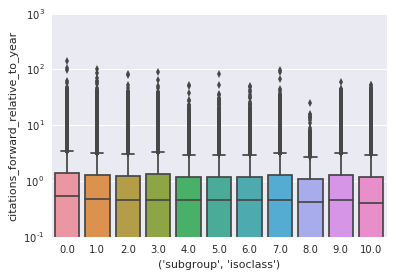

In [11]:
df = patent_properties[((patent_properties[('subgroup','n')]==4) *
                   (patent_properties['year']<2005)
                   )]

sns.boxplot(x=('subgroup', 'isoclass'), y='citations_forward_relative_to_year',
               data=df,
               )
yscale('log')

In [6]:
patent_properties[('subgroup','V_density')] = patent_properties[('subgroup','V_density')].values/(patent_properties[('subgroup','n')].values*(patent_properties[('subgroup','n')].values-1)/2)

y = patent_properties[(
                   (patent_properties['year']<2005)
                   )].groupby([('subgroup','V_density')])['citations_forward_relative_to_year'].mean()

y.rolling(100).mean().plot()

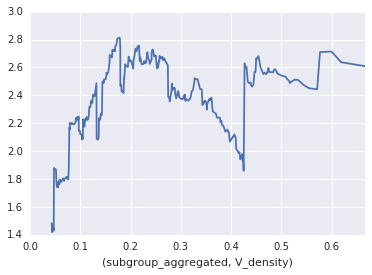

In [26]:
patent_properties[('subgroup_aggregated','V_density')] = patent_properties[('subgroup_aggregated','V_density')].values/(patent_properties[('subgroup_aggregated','n')].values*(patent_properties[('subgroup_aggregated','n')].values-1)/2)
y = patent_properties[(
                   (patent_properties['year']<2005)
                   )].groupby([('subgroup_aggregated','V_density')])['citations_forward_relative_to_year'].mean()

y.rolling(100).mean().plot()

In [36]:
from scipy.stats import rankdata

# from scipy.stats import scoreatpercentile
patent_properties['citations_forward_percentile_for_year'] = patent_properties.groupby('year')['citations_forward'].transform(lambda x: rankdata(x)/len(x))

In [39]:
patent_properties[((patent_properties[('subgroup','n')]==3) *
                   (patent_properties['year']<2005)
                   )].groupby([('subgroup','isoclass')])['citations_forward_percentile_for_year'].mean()

/home/jeffrey_alstott/anaconda3/lib/python3.4/site-packages/pandas/computation/expressions.py:181: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


(subgroup, isoclass)
0.0    0.505510
1.0    0.505316
2.0    0.506014
3.0    0.504909
Name: citations_forward_percentile_for_year, dtype: float64

/home/jeffrey_alstott/anaconda3/lib/python3.4/site-packages/pandas/computation/expressions.py:181: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


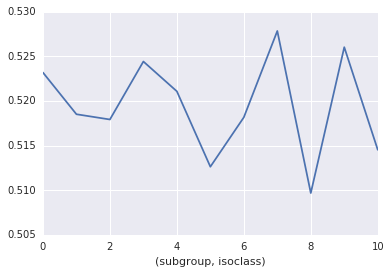

In [40]:
patent_properties[((patent_properties[('subgroup','n')]==4) *
                   (patent_properties['year']<2005)
                   )].groupby([('subgroup','isoclass')])['citations_forward_percentile_for_year'].mean().plot()

/home/jeffrey_alstott/anaconda3/lib/python3.4/site-packages/pandas/computation/expressions.py:181: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


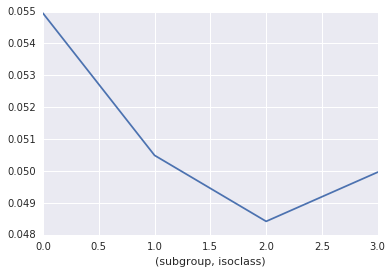

In [41]:
patent_properties[((patent_properties[('subgroup','n')]==3) *
                   (patent_properties['year']<2005)
                   )].groupby([('subgroup','isoclass')])['citations_forward_percentile_for_year'].apply(lambda x:(x>.95).mean()).plot()

/home/jeffrey_alstott/anaconda3/lib/python3.4/site-packages/pandas/computation/expressions.py:181: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


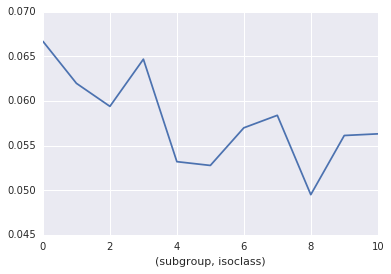

In [42]:
patent_properties[((patent_properties[('subgroup','n')]==4) *
                   (patent_properties['year']<2005)
                   )].groupby([('subgroup','isoclass')])['citations_forward_percentile_for_year'].apply(lambda x:(x>.95).mean()).plot()

/home/jeffrey_alstott/anaconda3/lib/python3.4/site-packages/pandas/computation/expressions.py:181: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


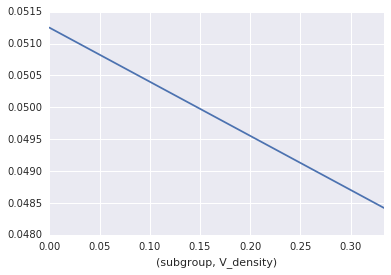

In [46]:
patent_properties[((patent_properties[('subgroup','n')]==3) *
                   (patent_properties['year']<2005)
                   )].groupby([('subgroup','V_density')])['citations_forward_percentile_for_year'].apply(lambda x:(x>.95).mean()).plot()

/home/jeffrey_alstott/anaconda3/lib/python3.4/site-packages/pandas/computation/expressions.py:181: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


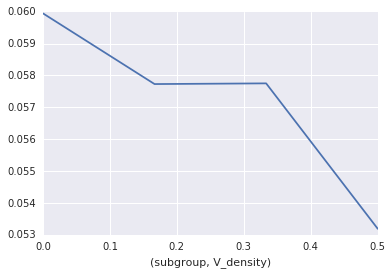

In [45]:
patent_properties[((patent_properties[('subgroup','n')]==4) *
                   (patent_properties['year']<2005)
                   )].groupby([('subgroup','V_density')])['citations_forward_percentile_for_year'].apply(lambda x:(x>.95).mean()).plot()

/home/jeffrey_alstott/anaconda3/lib/python3.4/site-packages/pandas/computation/expressions.py:181: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


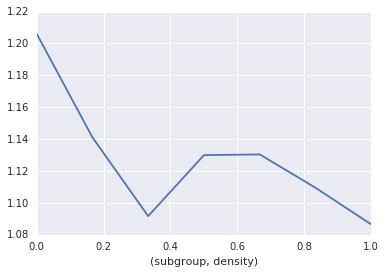

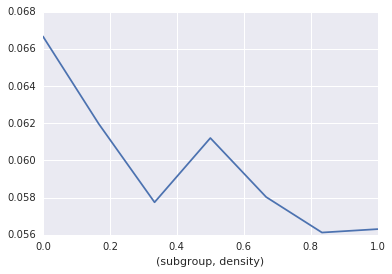

In [90]:
patent_properties[((patent_properties[('subgroup','n')]==4) *
                   (patent_properties['year']<2005)
                   )].groupby([('subgroup','density')])['citations_forward_relative_to_year'].mean().plot()

figure()
patent_properties[((patent_properties[('subgroup','n')]==4) *
                   (patent_properties['year']<2005)
                   )].groupby([('subgroup','density')])['citations_forward_percentile_for_year'].apply(lambda x:(x>.95).mean()).plot()

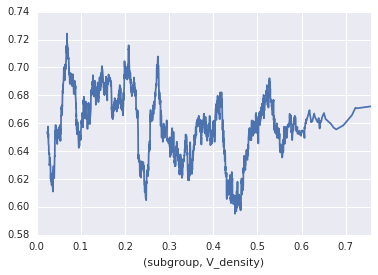

In [43]:
y = patent_properties[(
                   (patent_properties['year']<2005)
                   )].groupby([('subgroup','V_density')])['citations_forward_percentile_for_year'].mean()

y.rolling(100).mean().plot()

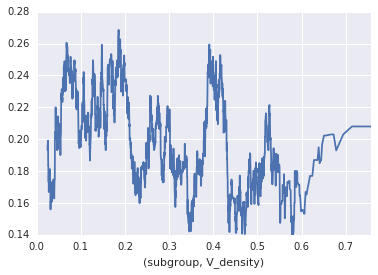

In [44]:
y = patent_properties[(
                   (patent_properties['year']<2005)
                   )].groupby([('subgroup','V_density')])['citations_forward_percentile_for_year'].apply(lambda x:(x>.95).mean())
y.rolling(100).mean().plot()

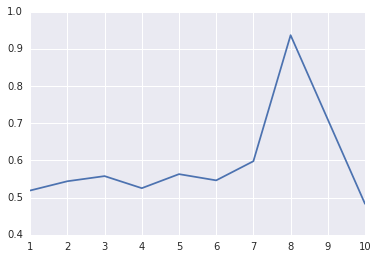

In [52]:
ind = patent_properties['year']<2005
y = patent_properties[ind].groupby(digitize(patent_properties[ind][('subgroup','V_density')], arange(0,1,.1)))['citations_forward_percentile_for_year'].mean()
y.plot()


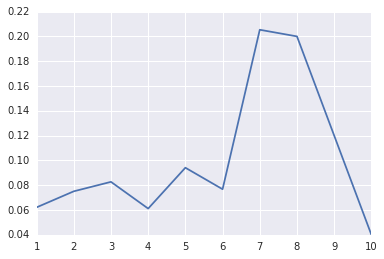

In [53]:
ind = patent_properties['year']<2005
y = patent_properties[ind].groupby(digitize(patent_properties[ind][('subgroup','V_density')], arange(0,1,.1)))['citations_forward_percentile_for_year'].apply(lambda x:(x>.95).mean())
y.plot()


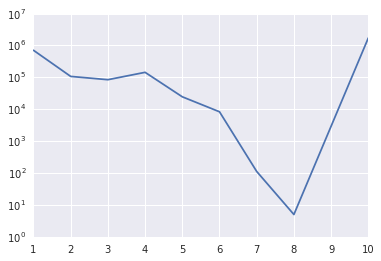

In [58]:
ind = patent_properties['year']<2005
y = patent_properties[ind].groupby(digitize(patent_properties[ind][('subgroup','V_density')], 
                                            arange(0,1,.1)))['citations_forward_percentile_for_year'].count()
y.plot()
yscale('log')


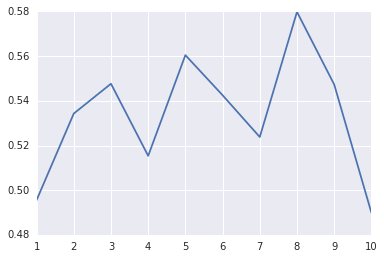

In [92]:
ind = patent_properties['year']<2005
y = patent_properties[ind].groupby(digitize(patent_properties[ind][('subgroup','density')], arange(0,1,.1)))['citations_forward_percentile_for_year'].mean()
y.plot()


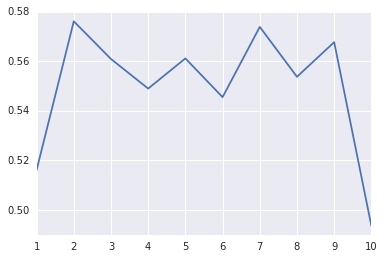

In [67]:
ind = patent_properties['year']<2005
y = patent_properties[ind].groupby(digitize(patent_properties[ind][('subgroup','transitivity')], 
                                            arange(0,1,.1)))['citations_forward_percentile_for_year'].mean()
y.plot()
# yscale('log')


/home/jeffrey_alstott/anaconda3/lib/python3.4/site-packages/pandas/computation/expressions.py:181: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


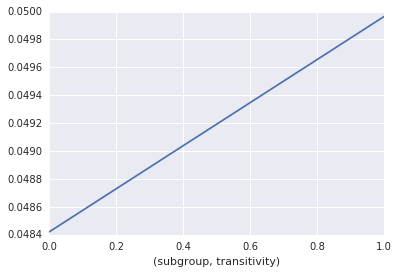

In [61]:
patent_properties[((patent_properties[('subgroup','n')]==3) *
                   (patent_properties['year']<2005)
                   )].groupby([('subgroup','transitivity')])['citations_forward_percentile_for_year'].apply(lambda x:(x>.95).mean()).plot()

/home/jeffrey_alstott/anaconda3/lib/python3.4/site-packages/pandas/computation/expressions.py:181: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


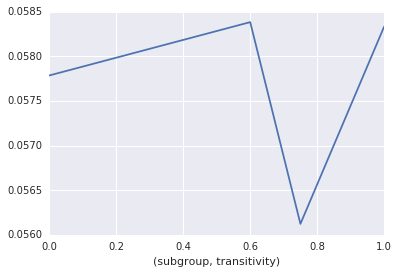

In [60]:
patent_properties[((patent_properties[('subgroup','n')]==4) *
                   (patent_properties['year']<2005)
                   )].groupby([('subgroup','transitivity')])['citations_forward_percentile_for_year'].apply(lambda x:(x>.95).mean()).plot()

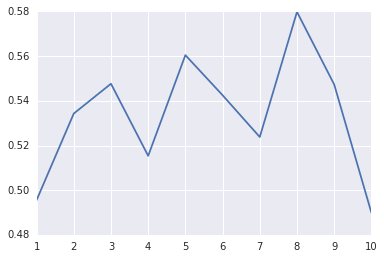

In [68]:
ind = patent_properties['year']<2005
y = patent_properties[ind].groupby(digitize(patent_properties[ind][('subgroup','density')], 
                                            arange(0,1,.1)))['citations_forward_percentile_for_year'].mean()
y.plot()
# yscale('log')


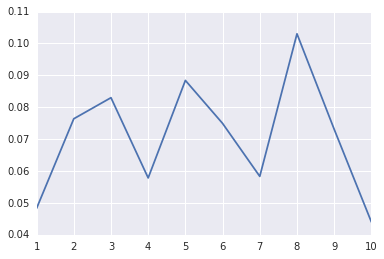

In [72]:
ind = patent_properties['year']<2005
y = patent_properties[ind].groupby(digitize(patent_properties[ind][('subgroup','density')], 
                                            arange(0,1,.1)))['citations_forward_percentile_for_year'].apply(lambda x:(x>.95).mean())
y.plot()
# yscale('log')


In [81]:
mean_performance = patent_properties[((patent_properties[('subgroup','n')]==4) *
                   (patent_properties['year']<2005)
                   )].groupby([('subgroup','isoclass')])['citations_forward_relative_to_year'].mean()
hit_probability = patent_properties[((patent_properties[('subgroup','n')]==4) *
                   (patent_properties['year']<2005)
                   )].groupby([('subgroup','isoclass')])['citations_forward_percentile_for_year'].apply(lambda x:(x>.95).mean())
mean_performance.sort_values(inplace=True)
hit_probability.sort_values(inplace=True)

/home/jeffrey_alstott/anaconda3/lib/python3.4/site-packages/pandas/computation/expressions.py:181: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


In [84]:
mean_performance

(subgroup, isoclass)
8.0     0.962462
5.0     1.054723
6.0     1.071495
10.0    1.086451
4.0     1.090326
2.0     1.103894
9.0     1.109476
7.0     1.137322
1.0     1.141198
3.0     1.163932
0.0     1.206231
Name: citations_forward_relative_to_year, dtype: float64

In [85]:
hit_probability

(subgroup, isoclass)
8.0     0.049496
5.0     0.052769
4.0     0.053191
9.0     0.056122
10.0    0.056306
6.0     0.056983
7.0     0.058382
2.0     0.059386
1.0     0.061965
3.0     0.064669
0.0     0.066667
Name: citations_forward_percentile_for_year, dtype: float64

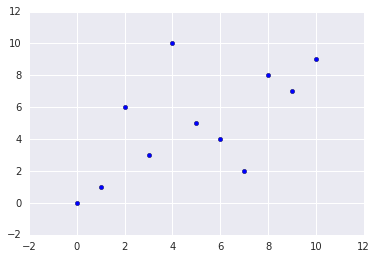

In [83]:
scatter(mean_performance.index.values,
        hit_probability.index.values)

So, if there is a positive effect of Vs, it's not just falling out of the subgroup data (or the unnormalized subgroup_aggregated data). Using this data (i.e. without z-scores) it seems that simply having more unusual combinations is a good thing (lower graph density -> more citations). Given a particular density, it seems more triangles might be a good thing? One thing that is clear is that it's going to be necessary to control for all these different factors to attempt to isolate any of their properties. So we're going to need to create a negative binomial model. 

So, maybe make the neg_binomial model first, and then after that try weighting things with z-scores?

In [ ]:
# http://www.graphclasses.org/smallgraphs.html#nodes4
# http://math.stackexchange.com/questions/599675/why-there-are-11-non-isomorphic-graphs-of-order-4
# http://math.stackexchange.com/questions/683765/how-can-we-make-11-non-isomorphic-graphs-on-4-vertices